In [1]:
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = ''

with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    for file in zip_ref.infolist():
      df = pd.DataFrame(pd.read_csv(zip_ref.open(file.filename)))

columns = [
    'id_persona',
    'genero',
    'edad',
    'ocupacion',
    'duracion_sueño',
    'calidad_sueño',
    'nivel_actividad_fisica',
    'nivel_estres',
    'BMI_categoria',
    'presion_sanguinea',
    'pulso_cardiaco',
    'pasos_diarios',
    'desorden_sueño'
]
df.columns = columns

df['genero'] = df['genero'].map({'Male':0,'Female':1})
df['BMI_categoria'] = df['BMI_categoria'].map({
    'Overweight':'Sobrepeso',
    'Normal':'Normal',
    'Obese':'Obeso',
    'Normal Weight':'Peso normal'
})

In [ ]:
#-----Probabilidad de tener un desorden de sueño
#-----en relacion a la ocupacion
porcentaje_ocupacio_desorden_sueno = {}
for ocupacion in df['ocupacion'].unique():
  df_m = df[(df['ocupacion'] == ocupacion)]
  porcentaje = round((df_m['desorden_sueño'].count() * 100) / len(df_m),2)
  porcentaje_ocupacio_desorden_sueno[ocupacion] = porcentaje

df_porcentaje_ocupacio_desorden_sueno = pd.DataFrame(porcentaje_ocupacio_desorden_sueno.values(),index=porcentaje_ocupacio_desorden_sueno.keys(),columns=['porcentaje'])

In [ ]:
print(
    f'''
Dos ocupaciones con mas encuestados
{(df.groupby('ocupacion')['id_persona'].count().sort_values(ascending=False))[:2]}
    '''
)


Dos ocupaciones con mas encuestados
ocupacion
Nurse     73
Doctor    71
Name: id_persona, dtype: int64
    


# Analisis por Ocupacion

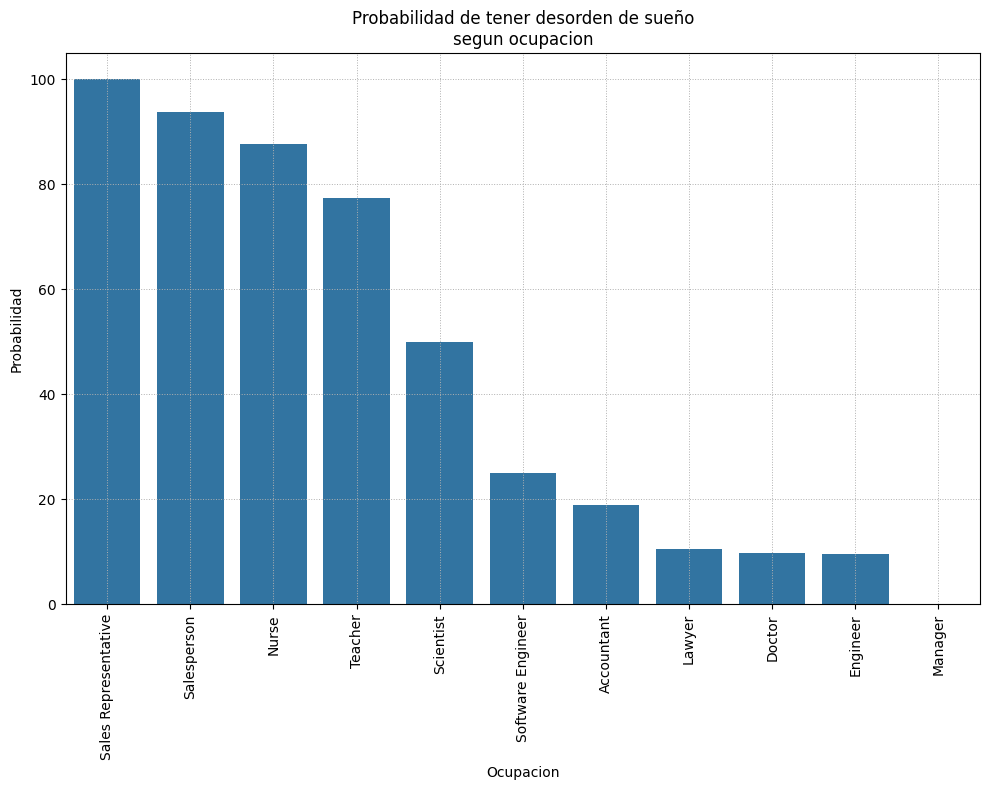

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(
    data = df_porcentaje_ocupacio_desorden_sueno.sort_values(
        by='porcentaje',
        ascending=False
    ),
    x = df_porcentaje_ocupacio_desorden_sueno.sort_values(
        by='porcentaje',
        ascending=False
        ).index,
    y = 'porcentaje'
)
plt.title('Probabilidad de tener desorden de sueño\nsegun ocupacion')
plt.ylabel('Probabilidad')
plt.xlabel('Ocupacion')
plt.xticks(rotation=90)
plt.grid(
    linestyle='dotted',
    linewidth=0.7
)
plt.tight_layout()
plt.show()

Observando el set de datos tomamos la decision de analizar que porsentaje de la muestra puede sufrir algun tipo de trastorno en el sueño dependiendo de la ocupacion que realiza, este analisis arrojo que los representantes de ventas tienen un 100% de probabilidad de sufrir algun tipo de trastorno del sueño, el problema con la muestra es que solo contiene dos personas con ese cargo y al ser una cantidad tan reducida puede no representar correctamente la realidad de la poblacion. Lo mismo ocurre con la ocupacion Manager que solo contiene 1 dato dentro de la muestra y nos dice que el 0% de los Manager poseen trastornos de sueño.

Dos ocupaciones del area de la medicina, enfermera y doctor poseen registros suficientes en la muestra para realizar un analisis que podria reflejar un poco mas acertadamente lo que ocurre con la poblacion. Los resultados indicaron que el 87% de las enfermeras poseen algun tipo de trastorno del sueño un porcentaje bastante alto comparado con el porcentaje de doctores que posee algun trastorno del sueño donde la cifra es solo un 9.8%.




In [2]:
nurse = df[df['ocupacion'] == 'Nurse']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_nurse = nurse[['edad','duracion_sueño','calidad_sueño','nivel_actividad_fisica','pasos_diarios']]

scalar = StandardScaler()
X_scaled = scalar.fit_transform(X_nurse)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca,columns=['PC1','PC2'])

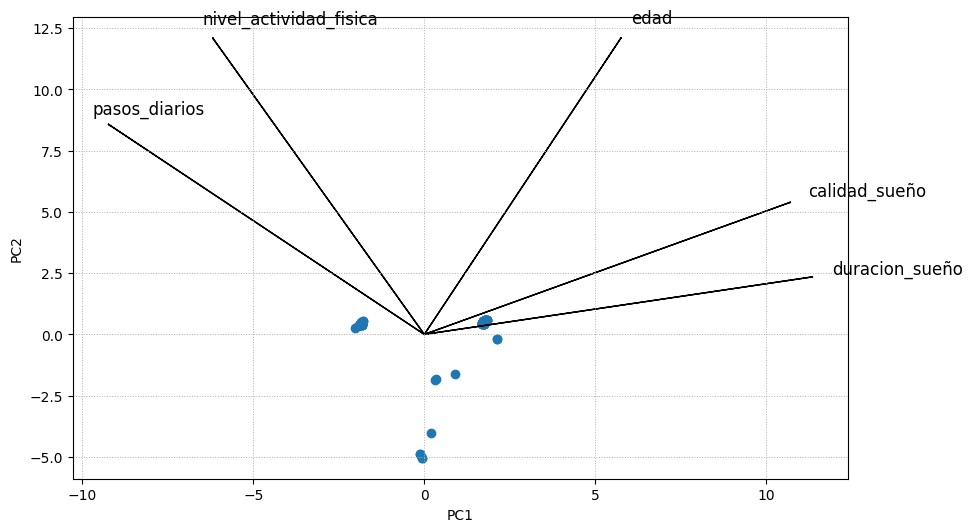

In [ ]:
plt.figure(figsize=(10,6))

plt.scatter(
    x=X_pca_df['PC1'],
    y=X_pca_df['PC2']
)
features=X_nurse.columns
for i,(comp1,comp2) in iter(enumerate(pca.components_.T)):
  plt.arrow(
      x=0,
      y=0,
      dx=comp1*20,
      dy=comp2*20,
      head_width=0.05,
      head_length=0
  )
  plt.text(
      x=comp1*21,
      y=comp2*21,
      s=features[i],
      fontsize=12
  )

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.grid(
    linestyle='dotted',
    linewidth=0.7
)

plt.show()

En el grafico anterior podemos ver como se relacionan las variables entre si, en este caso el nivel de actividad fisica estan altamente ligados a la cantidad de pasos diarios que da una persona, como tambien la calidad del sueño con la duracion del mismo. Tambien podemos apreciar que mientras la edad aumenta el nivel de actividad fisica comienza a disminuir, pero no asi la calidad del sueño que pareciera aumentar conforme lo hace la edad

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

def datosRegresion(x,y):
  X = x
  y = y

  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

  model = LinearRegression()
  model.fit(X_train,y_train)

  y_pred = model.predict(X_test)
  return X_test,y_pred

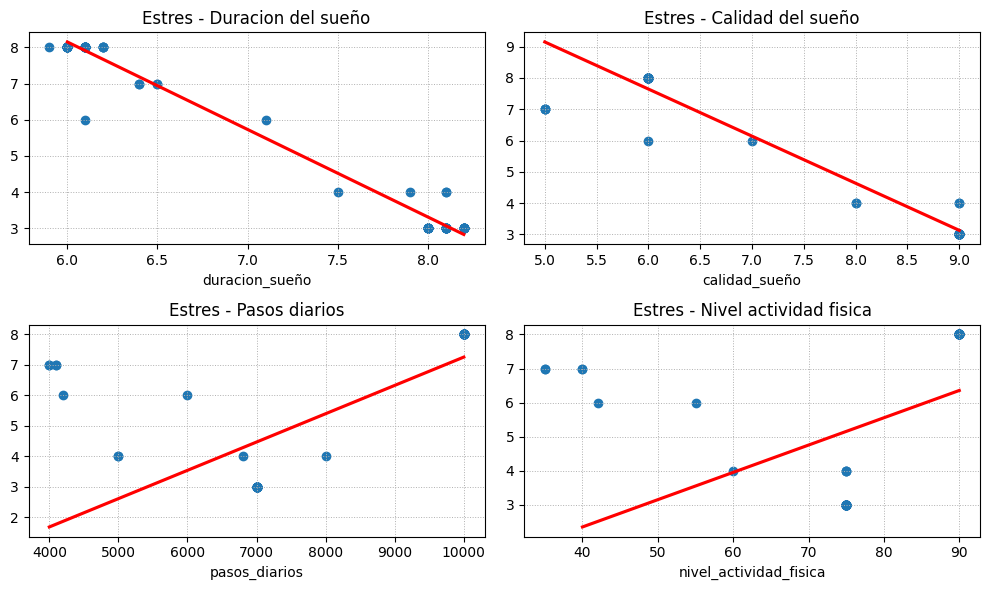

In [ ]:
plt.figure(figsize=(10,6))
#------Duracion Sueño
#------Nivel estres
plt.subplot(2,2,1)
plt.scatter(
    x=nurse[['duracion_sueño']],
    y= nurse[['nivel_estres']]
)
sns.regplot(
    x = datosRegresion(nurse[['duracion_sueño']],nurse['nivel_estres'])[0],
    y = datosRegresion(nurse[['duracion_sueño']],nurse['nivel_estres'])[1],
    color='red',
    scatter=False
)
plt.title('Estres - Duracion del sueño')
plt.grid(
    linestyle='dotted',
    linewidth=0.7
)

#----Calidad sueño
#----Nivel estres
plt.subplot(2,2,2)
plt.scatter(
    x=nurse[['calidad_sueño']],
    y= nurse[['nivel_estres']]
)
sns.regplot(
    x = datosRegresion(nurse[['calidad_sueño']],nurse['nivel_estres'])[0],
    y = datosRegresion(nurse[['calidad_sueño']],nurse['nivel_estres'])[1],
    color='red',
    scatter=False
)
plt.title('Estres - Calidad del sueño')
plt.grid(
    linestyle='dotted',
    linewidth=0.7
)

#----Pasos diarios
#----Nivel estres
plt.subplot(2,2,3)
plt.scatter(
    x=nurse[['pasos_diarios']],
    y= nurse[['nivel_estres']]
)
sns.regplot(
    x = datosRegresion(nurse[['pasos_diarios']],nurse['nivel_estres'])[0],
    y = datosRegresion(nurse[['pasos_diarios']],nurse['nivel_estres'])[1],
    color='red',
    scatter=False
)
plt.title('Estres - Pasos diarios')
plt.grid(
    linestyle='dotted',
    linewidth=0.7
)

#----Nivel actividad fisica
#----Nivel estres
plt.subplot(2,2,4)
plt.scatter(
    x=nurse[['nivel_actividad_fisica']],
    y= nurse[['nivel_estres']]
)
sns.regplot(
    x = datosRegresion(nurse[['nivel_actividad_fisica']],nurse['nivel_estres'])[0],
    y = datosRegresion(nurse[['nivel_actividad_fisica']],nurse['nivel_estres'])[1],
    color='red',
    scatter=False
)
plt.title('Estres - Nivel actividad fisica')
plt.grid(
    linestyle='dotted',
    linewidth=0.7
)
plt.tight_layout()
plt.show()

Para continuar con el analisis se realizo un regresion lineal entre la variable estre y otras variables asociadas al sueño y otras asociadas a la actividad fisica, al parecer las variables de estudio se comportan de manera similar. La duracion del sueño junto con la calidad de este al aumentar disminuye el estres, no asi las variables asociadas a la actividad fisica, que nos indican que ha mayor actividad fisica mayor es el nivel de estres que puede persivir una persona

Al analizar una de las ocupaciones con mas usuarios encuestados pudimos determinar que la calidad y cantidad de horas de sueño que tiene una persona afectan positivamente la sensacion de estres percibida por el usuario, y que el nivel de actividad fisica tiene un impacto negativo en el nivel de estres percibido por una persona

# Analisis por BMI

In [ ]:
BMI_categorias = df['BMI_categoria'].unique()
porcentajes = {}
for categoria in BMI_categorias:
  df_m = df[df['BMI_categoria'] == categoria]
  porcentaje = round((df_m['desorden_sueño'].count() * 100) / len(df_m),2)
  porcentajes[categoria] = porcentaje

df_porcentajes_BMI = pd.DataFrame(
    porcentajes.values(),
    index=porcentajes.keys(),
    columns=['porcentaje']
)

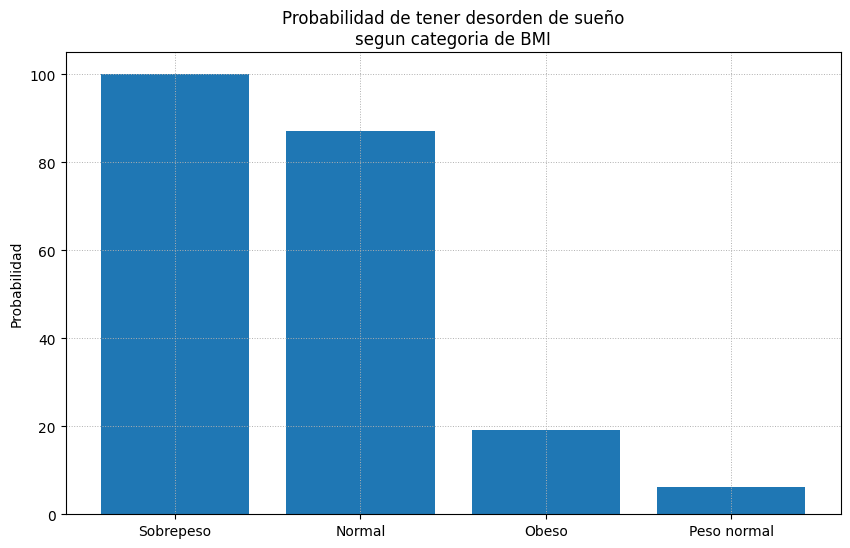

In [ ]:
plt.figure(figsize=(10,6))

plt.bar(
    x=df_porcentajes_BMI.index,
    height=df_porcentajes_BMI['porcentaje'].sort_values(ascending=False)
)
plt.title('Probabilidad de tener desorden de sueño\nsegun categoria de BMI')
plt.ylabel('Probabilidad')
plt.grid(
    linestyle='dotted',
    linewidth=0.7
)

plt.show()

Al analizar que tan probable es que una persona posea algun tipo de trastorno del sueño basandoce en el BMI que posee, nos podemos dar cuenta que existe una alta probabilidad en caso de estar dentro de la categoria de 'Sobrepeso' y en la categoria 'Normal'.

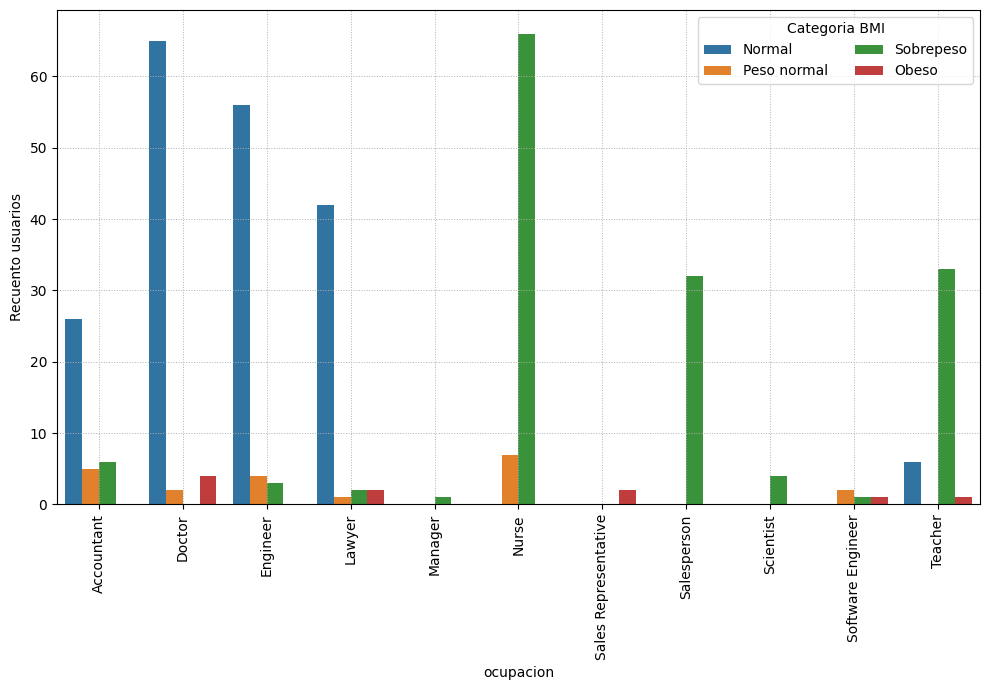

In [ ]:
ocupacion_BMI = df.groupby(['ocupacion','BMI_categoria'])[['id_persona']].count()
plt.figure(figsize=(10,7))

sns.barplot(
    data=ocupacion_BMI,
    x = ocupacion_BMI.index.get_level_values(0),
    y = 'id_persona',
    hue = ocupacion_BMI.index.get_level_values(1),
)
plt.ylabel('Recuento usuarios')

plt.xticks(rotation=90)
plt.grid(
    linestyle='dotted',
    linewidth=0.7
)
plt.legend(
    loc='upper right',
    title='Categoria BMI',
    ncol=2
)
plt.tight_layout()
plt.show()

En el grafico anterior hemos agrupado los datos por ocupacion y por nivel de BMI, de esta manera podemos identificar cual de las ocupaciones puede tener usuarios con altos indices de BMI e identificar si esto tiene alguna relacion con el padecimiento de trastornos del sueño, a simple vista podemos ver que la ocupacion Nurse enfermera tiene una alta cantidad de usuarios en la categoria sobrepeso.

Lo siguiente sera determinar que porcentaje de las enfermeras en la categoria de sobrepeso poseen algun tipo de trastorno del sueño.

In [ ]:
nurse

,id_persona,genero,edad,ocupacion,duracion_sueño,calidad_sueño,nivel_actividad_fisica,nivel_estres,BMI_categoria,presion_sanguinea,pulso_cardiaco,pasos_diarios,desorden_sueño
16,17,1,29,Nurse,6.5,5,40,7,Peso normal,132/87,80,4000,Sleep Apnea
18,19,1,29,Nurse,6.5,5,40,7,Peso normal,132/87,80,4000,Insomnia
30,31,1,30,Nurse,6.4,5,35,7,Peso normal,130/86,78,4100,Sleep Apnea
31,32,1,30,Nurse,6.4,5,35,7,Peso normal,130/86,78,4100,Insomnia
32,33,1,31,Nurse,7.9,8,75,4,Peso normal,117/76,69,6800,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,1,59,Nurse,8.1,9,75,3,Sobrepeso,140/95,68,7000,Sleep Apnea
370,371,1,59,Nurse,8.0,9,75,3,Sobrepeso,140/95,68,7000,Sleep Apnea
371,372,1,59,Nurse,8.1,9,75,3,Sobrepeso,140/95,68,7000,Sleep Apnea
372,373,1,59,Nurse,8.1,9,75,3,Sobrepeso,140/95,68,7000,Sleep Apnea


In [ ]:
df_provisorio = nurse[nurse['BMI_categoria'] == 'Sobrepeso'].groupby('desorden_sueño')[['id_persona']].count()
p_sobrepeso_sueno = round(df_provisorio['id_persona'].sum() * 100 / len(nurse[nurse['BMI_categoria'] == 'Sobrepeso']),2)
sizes = [p_sobrepeso_sueno,100-p_sobrepeso_sueno]
labels = ['Posee desorden\nde sueño','No posee\ndesorden de sueño']

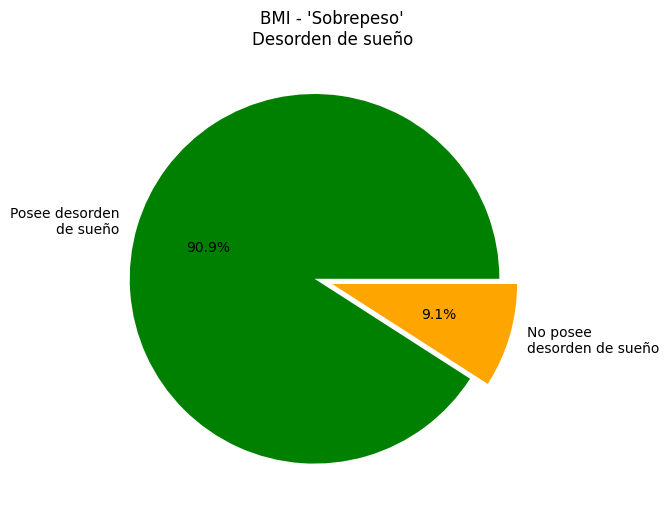

In [ ]:
plt.figure(figsize=(10,6))

explode = (0.1,0)
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=['green','orange'],
    explode=explode
)

plt.title("BMI - 'Sobrepeso'\nDesorden de sueño")

plt.show()

En el grafico anterior podemos visualizar el porcetaje de enfermeras que estan dentro de la categoria sobrepeso del BMI que poseen algun tipo de desorden del sueño.

Despues de los analisis anteriores podemos llegar a la conclusion de que tanto la calidad del sueño, el tener un estilo de vida activo o tener un IMC ligeramente elevado podrian influir significativamente en el nivel de estres de una persona. Si bien este no es un nivel alto dentro de lo que son las categorias de IMC el entorno podria ser bastante influyente ya que esta podria alterar su propia percepción de IMC y afectar negativamente su nivel de estres.

En un entorno de trabajo demandante el buen descanso puede ayudar de manera favorable a disminuir el estres, por el contrario el nivel de pasos de una persona nos puede indicar que fue un trabajo o turno movido, lo que estaria relacionado a la alta cantidad de estres percibida por el usuario, ya que de los datos obtenidos pudimos rescatar que una alta cantidad de pasos diarios o actividad fisica esta relacionado con un alto nivel de estres, dentro de lo que viene siendo la ocupacion enfermera.